In [3]:
import copy
import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn3
from tqdm import tqdm

from vnc_networks import MANC, UID, CMatrix, Connections, params
from vnc_networks.utils import plots_design


In [4]:
# ----- Directories
manc_version = "v1.2"
MDN_DIR = "overall_VNC"
FIG_DIR = MANC(manc_version).get_fig_dir()
MDN_FIGS = os.path.join(FIG_DIR, MDN_DIR)
os.makedirs(MDN_FIGS, exist_ok=True)


In [5]:
savefigs = False  # True to save figures

In [6]:
CR = MANC(manc_version)
vanilla_vnc = Connections(CR=CR)  # no neuron splitting or anything

Attribute class_1 not found in the graph. Adding it.


# Control that high degree interneurons are not necessarily gabaergic 

## Overall VNC

In [7]:
all_neurons = vanilla_vnc.get_nodes()
df_degree = pd.DataFrame({"uid": all_neurons})
df_degree["nt_type"] = vanilla_vnc.get_node_attribute(
    uid=all_neurons, attribute="nt_type"
)
df_degree = df_degree[
    (df_degree["nt_type"] != "None")
    & (df_degree["nt_type"] != "unknown")
    & (df_degree["nt_type"] != "unclear")
]
df_degree["out_degree"] = df_degree["uid"].apply(
    lambda x: vanilla_vnc.get_out_degree(x)
)
df_degree["in_degree"] = df_degree["uid"].apply(lambda x: vanilla_vnc.get_in_degree(x))


Attribute nt_type not found in the graph. Adding it.


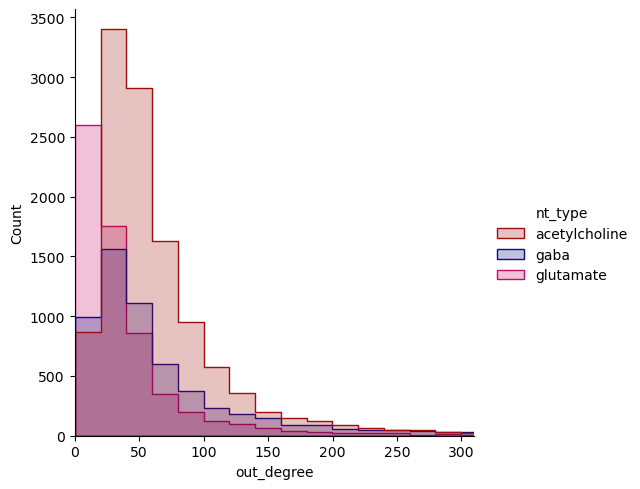

In [8]:
# 99th percentile of out_degree
p99 = np.percentile(df_degree["out_degree"].values, q=99)

# binning
bin_size = 20

nt_types = np.unique(df_degree["nt_type"])
palette = [params.NT_TYPES[nt]["color"] for nt in nt_types]

grid = sns.displot(
    data=df_degree,
    x="out_degree",
    hue="nt_type",
    kind="hist",
    element="step",
    palette=palette,
    binwidth=bin_size,
)
grid.ax.set_xlim([0, p99])

if savefigs:
    plt.savefig(
        os.path.join(MDN_FIGS, "vnc_out_degree_per_nt_type.pdf"),
        dpi=params.DPI,
        bbox_inches="tight",
    )

plt.show()


There are more excitatory than gabaergic neurons with a high out degree, therefore finding gabaergic neurons as being the main hubs is not statistically expected.

Another way to look at this is to estimate the conditional probability distribution of getting a neuron with a certain nt_type given it's degree.
`P(nt = n | deg = d) = P(deg = d | nt = n) * P(nt = n) / P(deg = d)`
with all these probabilities being given by estimates on the data.

In [9]:
def P_deg(d: int, df: pd.DataFrame, bin=5):
    """
    Estimated probability of getting a neuron with out degree d.
    """
    data = df.loc[(df["out_degree"] >= d - bin) & (df["out_degree"] < d + bin)]
    return len(data) / len(df)


def P_nt(n: str, df: pd.DataFrame):
    """
    Estimated probability of getting a neuron with nt_type n.
    """
    data = df.loc[df["nt_type"] == n]
    return len(data) / len(df)


def P_deg_given_nt(d: int, n: str, df: pd.DataFrame, bin=5):
    """
    Estimated conditional probability of getting a neuron of degree d given its nt_type.
    """
    data = df.loc[
        (df["out_degree"] >= d - bin)
        & (df["out_degree"] < d + bin)
        & (df["nt_type"] == n)
    ]
    nt_specific_df = df.loc[df["nt_type"] == n]
    return len(data) / len(nt_specific_df)


def P_nt_given_deg(n: str, d: int, df: pd.DataFrame, bin=5):
    """
    Computed conditional probability of getting a neuron of degree d given its nt_type.
    """
    proba = (
        P_deg_given_nt(d=d, n=n, df=df, bin=bin)
        * P_nt(n=n, df=df)
        / P_deg(d=d, df=df, bin=bin)
    )
    return proba


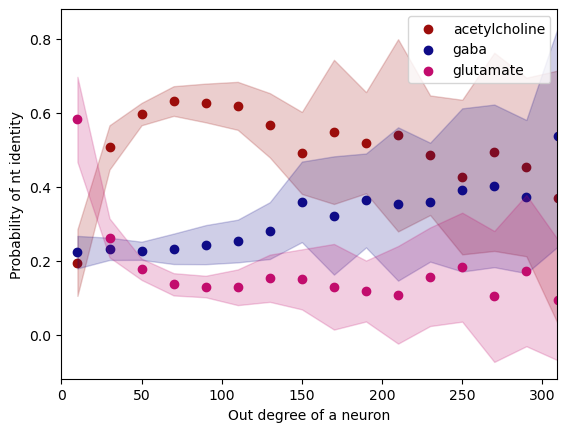

In [10]:
nt_types = np.unique(df_degree["nt_type"])

bin_e = bin_size // 2
max_x = int(p99 // bin_size) * bin_size + bin_e
nb_x = (max_x - bin_e) // bin_size + 1
X = np.linspace(bin_e, max_x, nb_x)

defined_degrees = np.unique(df_degree["out_degree"].values)

fig, axs = plt.subplots(1, 1)

for i, nt in enumerate(nt_types):
    # Estimate the probability with binned data
    conditional_proba = [P_nt_given_deg(nt, d, df_degree, bin=bin_e) for d in X]

    # Error bar estimation on std
    error_bar_up, error_bar_low = [], []
    for j, x in enumerate(X):
        degrees = [d for d in defined_degrees if ((d >= x - bin_e) & (d < x + bin_e))]
        individual_cps = [P_nt_given_deg(nt, d, df_degree, bin=0.5) for d in degrees]
        error_bar_up.append(conditional_proba[j] + np.std(individual_cps))
        error_bar_low.append(conditional_proba[j] - np.std(individual_cps))

    # plot results
    color = params.NT_TYPES[nt]["color"]
    axs.scatter(X, conditional_proba, label=nt, c=color)
    axs.fill_between(
        X,
        error_bar_low,
        error_bar_up,
        alpha=0.2,
        color=color,
    )


axs.legend()
axs.set_xlim([0, p99])
axs.set_xlabel("Out degree of a neuron")
axs.set_ylabel("Probability of nt identity")

if savefigs:
    plt.savefig(
        os.path.join(MDN_FIGS, "conditional_proba_nt_type_vs_out_degree_full_vnc.pdf"),
        dpi=params.DPI,
        bbox_inches="tight",
    )

plt.show()


There is no degree range for which picking a high degree neuron is more likely to return a gabaergic neuron. The fact that we do get that when lookng at the MDN-induced motor neuron clustering in T3 is therefore a specific pattern likely to have its importance.

## Specifically premotor neurons

In [11]:
# Identify premotor neurons
leg_motor_neurons = set()
for leg in ['fl', 'ml', 'hl']:
    mns = vanilla_vnc.get_neuron_ids(
        {
            "class_1": "motor", # Will also give wing etc motor neurons
            "class_2": leg,
        }
    )
    leg_motor_neurons = leg_motor_neurons.union(set(mns))
vnc_matrix = vanilla_vnc.get_cmatrix(type_="unnorm") # Faster to do this way
leg_premotor_neurons = vnc_matrix.list_upstream_neurons(list(leg_motor_neurons))
print(
    f"Found {len(leg_motor_neurons)} leg motor neurons and {len(leg_premotor_neurons)} premotor neurons"
)

Found 395 leg motor neurons and 6571 premotor neurons


In [12]:
# Compute the connectivity degree
df_degree = pd.DataFrame({"uid": leg_premotor_neurons})
df_degree["nt_type"] = vanilla_vnc.get_node_attribute(
    uid=leg_premotor_neurons, attribute="nt_type"
)
df_degree = df_degree[
    (df_degree["nt_type"] != "None")
    & (df_degree["nt_type"] != "unknown")
    & (df_degree["nt_type"] != "unclear")
]
df_degree["out_degree"] = df_degree["uid"].apply(
    lambda x: vanilla_vnc.get_out_degree(x)
)
df_degree["in_degree"] = df_degree["uid"].apply(
    lambda x: vanilla_vnc.get_in_degree(x)
    )

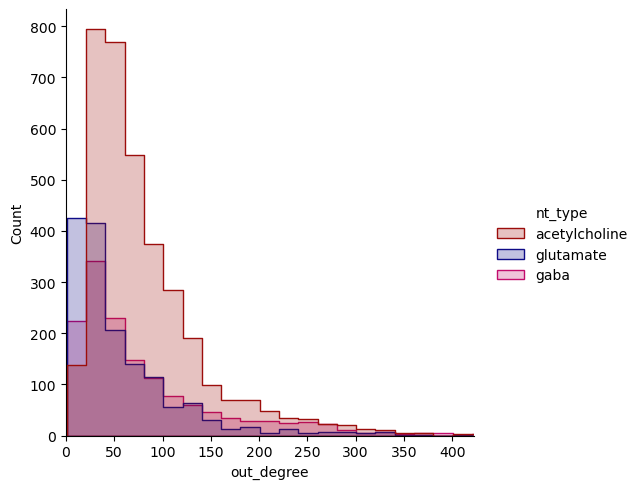

In [13]:
# 99th percentile of out_degree
p99 = np.percentile(df_degree["out_degree"].values, q=99)

# binning
bin_size = 20

nt_types = np.unique(df_degree["nt_type"])
palette = [params.NT_TYPES[nt]["color"] for nt in nt_types]

grid = sns.displot(
    data=df_degree,
    x="out_degree",
    hue="nt_type",
    kind="hist",
    element="step",
    palette=palette,
    binwidth=bin_size,
)
grid.ax.set_xlim([0, p99])

if savefigs:
    plt.savefig(
        os.path.join(MDN_FIGS, "vnc_out_degree_per_nt_type.pdf"),
        dpi=params.DPI,
        bbox_inches="tight",
    )

plt.show()


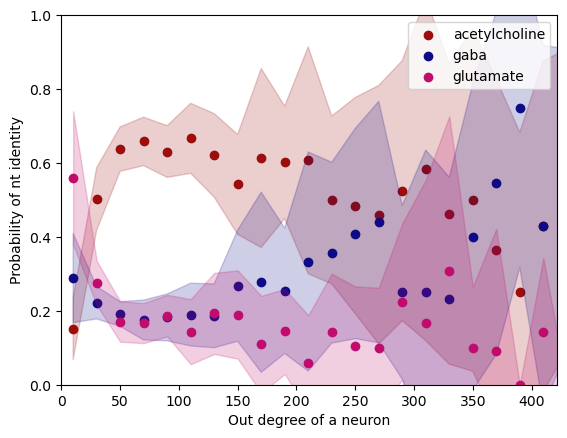

In [14]:
nt_types = np.unique(df_degree["nt_type"])

bin_e = bin_size // 2
max_x = int(p99 // bin_size) * bin_size + bin_e
nb_x = (max_x - bin_e) // bin_size + 1
X = np.linspace(bin_e, max_x, nb_x)

defined_degrees = np.unique(df_degree["out_degree"].values)

fig, axs = plt.subplots(1, 1)

for i, nt in enumerate(nt_types):
    # Estimate the probability with binned data
    conditional_proba = [P_nt_given_deg(nt, d, df_degree, bin=bin_e) for d in X]

    # Error bar estimation on std
    error_bar_up, error_bar_low = [], []
    for j, x in enumerate(X):
        degrees = [d for d in defined_degrees if ((d >= x - bin_e) & (d < x + bin_e))]
        individual_cps = [P_nt_given_deg(nt, d, df_degree, bin=0.5) for d in degrees]
        error_bar_up.append(conditional_proba[j] + np.std(individual_cps))
        error_bar_low.append(conditional_proba[j] - np.std(individual_cps))

    # plot results
    color = params.NT_TYPES[nt]["color"]
    axs.scatter(X, conditional_proba, label=nt, c=color)
    axs.fill_between(
        X,
        error_bar_low,
        error_bar_up,
        alpha=0.2,
        color=color,
    )


axs.legend()
axs.set_xlim([0, p99])
axs.set_ylim([0, 1])
axs.set_xlabel("Out degree of a neuron")
axs.set_ylabel("Probability of nt identity")

if savefigs:
    plt.savefig(
        os.path.join(MDN_FIGS, "conditional_proba_nt_type_vs_out_degree_full_vnc_premotor_only.pdf"),
        dpi=params.DPI,
        bbox_inches="tight",
    )

plt.show()


# DN to MN connections

## 1 and 2 hop connections

In [15]:
# Define a new connectome from which connections between motor neurons are removed
mn_bids = vanilla_vnc.get_neuron_bodyids({'class_1': 'motor'})
vnc_clean_mns = Connections(CR=CR, not_connected=mn_bids)

Attribute class_1 not found in the graph. Adding it.


In [16]:
# Input and output populations
motor_neurons = vnc_clean_mns.get_neuron_ids(
    {
        "class_1": "motor", # Will also give wing etc motor neurons
    }
)
descending_neurons = vnc_clean_mns.get_neuron_ids(
    {
        "class_1": "descending",
    }
)
cmat_clean = vnc_clean_mns.get_cmatrix(type_="syn_count") # Faster to do this way

In [17]:
# Connections at + and - 1
post_dn_neurons = cmat_clean.list_downstream_neurons(descending_neurons)
pre_mn_neurons = cmat_clean.list_upstream_neurons(motor_neurons)

In [18]:
# Identify premotor neurons
print(
    f"Found {len(descending_neurons)} descending neurons and {len(post_dn_neurons)} neurons directly downstream"
)
print(
    f"Found {len(motor_neurons)} motor neurons and {len(pre_mn_neurons)} premotor neurons"
)
all_nodes = vnc_clean_mns.get_nodes()
print(f"Found {len(all_nodes)} neurons in the VNC")


Found 1328 descending neurons and 15958 neurons directly downstream
Found 736 motor neurons and 11830 premotor neurons
Found 23543 neurons in the VNC


In [19]:
# How many MNs are within 2 hops of DNs?
cmat_clean.power_n(2)

In [20]:
dn_mns = cmat_clean.list_downstream_neurons(descending_neurons)
dn_mns = [n for n in dn_mns if n in motor_neurons]
print(
    f"Found {len(dn_mns)} out of {len(motor_neurons)} motor neurons downstream of DNs in 2 hops"
)


KeyboardInterrupt: 

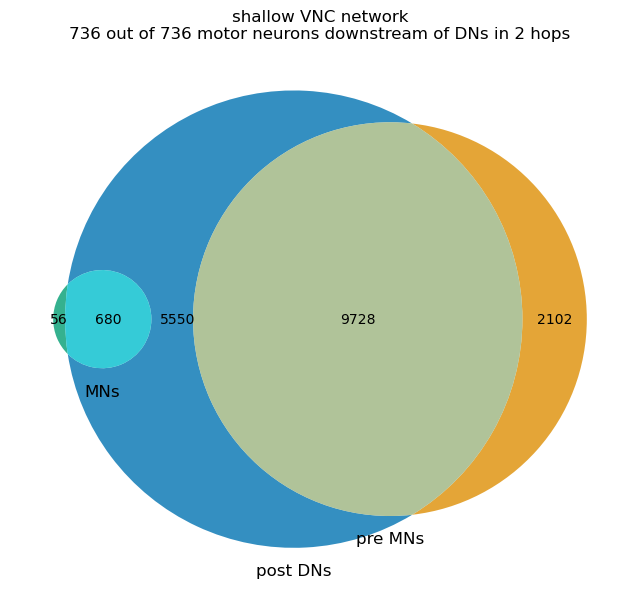

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=params.FIGSIZE)

colors = params.custom_palette[:3]
v = venn3(
    [set(post_dn_neurons), set(motor_neurons), set(pre_mn_neurons)],
    ("post DNs","MNs", 'pre MNs'),
    ax=ax,
    set_colors=colors,
    alpha=0.8,
)
ax.set_title(
    "shallow VNC network" + '\n'
    + f"{len(dn_mns)} out of {len(motor_neurons)} motor neurons downstream of DNs in 2 hops"
    )

if savefigs:
    plt.savefig(
        os.path.join(MDN_FIGS, "venn_diagram_premotor_neurons_vs_post-dns.pdf"),
        dpi=params.DPI,
        bbox_inches="tight",
    )


## Dependency on synapse thresholding

In [23]:
def ratio_intersection(
        vnc_: Connections,
        motor_neurons_: list[UID],
        descending_neurons_: list[UID],
        threshold: int = 0,):
    """
    Look at the intersection between [motor_neurons, pre_mn_neurons] and [post_dn_neurons]
    in terms of existing connections, as a function of the synapse threshold
    use to define a valid connection.
    Compute the ratio of the intersection to size of the minimal set (theoretically 1
    if the two sets are included in each other).
    This allows to quantify how much the DNs can talk directly or within 2 hops to the MNs.

    ! Warning: the numebr of premotor and post-dn neuron changes with the threshold
    as well, they are not fixed populations.
    """
    df_ = copy.deepcopy(vnc_.get_dataframe())

    # Remove all the entries with 'syn_count' < threshold
    df_ = df_[df_["syn_count"] >= threshold]
    
    # Identify the premotor neurons and the post-dn neurons
    premotor_neurons_ = np.unique(
        df_[df_["end_uid"].isin(motor_neurons_)]["start_uid"].values
    )
    mn_and_premnms_ = set(premotor_neurons_) | set(motor_neurons_)
    post_dn_neurons_ = np.unique(
        df_[df_["start_uid"].isin(descending_neurons_)]["end_uid"].values
    )

    # Maximum number of neurons in the smallest set:
    total_pool_ = min(len(post_dn_neurons_),len(mn_and_premnms_))
    if total_pool_ == 0:
        return np.nan, 0
    
    # Intersection of interest
    pre_and_post_ = set(mn_and_premnms_) & set(post_dn_neurons_)

    # Ratio of the intersection to the size of the smallest set
    ratio_ = len(pre_and_post_) / total_pool_

    return ratio_, total_pool_




In [24]:
theta = np.arange(0, 700, 1)
ratios = np.zeros(len(theta))
pool_size = np.zeros(len(theta))
for i, t in enumerate(theta):
    ratios[i], pool_size[i] = ratio_intersection(
        vnc_clean_mns,
        motor_neurons_=motor_neurons,
        descending_neurons_=descending_neurons,
        threshold=t,
    )



In [ ]:
# WARNING: this is veeeeery slow
# For each random seed and each theta value, it needs to resample
# the entire connectome and find connectivity intersections

nb_random = 100
rand_pool_size = np.zeros((nb_random, len(theta)))
rand_ratios = np.zeros((nb_random, len(theta)))

for i in tqdm(range(nb_random)):
    random_inputs = np.random.choice(
        all_nodes, len(descending_neurons), replace=False
    )
    random_outputs = np.random.choice(
        all_nodes, len(motor_neurons), replace=False
    )
    rand_ratios[i, :] = np.zeros(len(theta))
    rand_pool_size[i, :] = np.zeros(len(theta))
    for j, t in enumerate(theta):
        rand_ratios[i, j], rand_pool_size[i, j] = ratio_intersection(
            vnc_clean_mns,
            motor_neurons_=random_outputs,
            descending_neurons_=random_inputs,
            threshold=t,
        )

100%|██████████| 100/100 [1:14:15<00:00, 44.56s/it]


In [21]:
mean_rand = np.mean(rand_ratios, axis=0)
std_rand = np.std(rand_ratios, axis=0)

print("Comparison with random neuron pools of the same size:")
for t in [5, 10, 40 , 100, 500]:
    print(f"theshold {t}: {100*mean_rand[t]:.2f}% overlap")

if savefigs:
    stats_file = os.path.join(MDN_FIGS, "stats.txt")
    with open(stats_file, "w") as f:
        f.write(f"Comparison with {nb_random} random neuron pools of the same size:\n")
        for t in [5, 10, 40 , 100, 500]:
            f.write(f"theshold {t}: {100*mean_rand[t]:.2f}% overlap\n")

NameError: name 'rand_ratios' is not defined

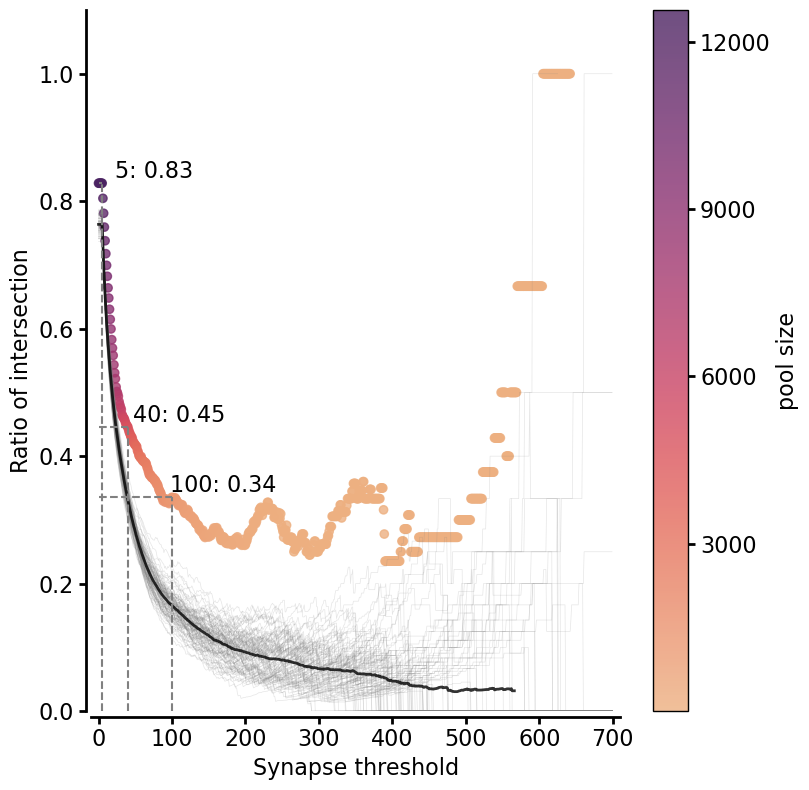

In [75]:
fig, ax = plt.subplots(1, 1, figsize=params.FIGSIZE)

for i in range(nb_random): # Random single traces as thin grey lines
    ax.plot(
        rand_ratios[i, :],
        c="grey",
        linewidth=0.5,
        alpha=0.2,
    )

# Plot the mean and the std of the random traces as a thick grey line and shaded area
ax.plot(
    mean_rand,
    c="k",
    linewidth=2,
    alpha=0.8,
    label="random (mean)",
)

ax = plots_design.scatter_xyz_2d(
    X=theta,
    Y=ratios,
    Z=pool_size,
    ax=ax,
    cmap=params.red_colorscale,
    z_label="pool size",
)
ax.set_ylim([0, 1.1])
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_xlim([-10, 710])
ax.set_xticks(np.arange(0, 710, 100))
ax.set_xlabel("Synapse threshold")
ax.set_ylabel("Ratio of intersection")

# highlight a few notable points
highlights = [5, 40, 100]
for h in highlights:
    ax.vlines(
        x=h,
        ymin=0,
        ymax=ratios[h],
        color="grey",
        linestyle="--",
    )
    ax.hlines(
        y=ratios[h],
        xmin=0,
        xmax=h,
        color="grey",
        linestyle="--",
    )
    ax.text(
        x=h + 70,
        y=ratios[h],
        s=f"{h}: {ratios[h]:.2f}",
        fontsize=params.LABEL_SIZE,
        ha="center",
        va="bottom",
    )

if savefigs:
    plt.savefig(
        os.path.join(MDN_FIGS, "ratio_intersection_premotor_neurons_vs_post-dns_fnctn_syn_threshold_baseline.pdf"),
        dpi=params.DPI,
        bbox_inches="tight",
        transparent=True,
    )
plt.show()


# Graph layering

## Histogram of layer sizes
We work with the vanilla VNC, except that connecitons between motor neurons are ignored to be really considered as the output layer.

In [25]:
clean_cmat = vnc_clean_mns.get_cmatrix(type_="unnorm")

assigned_neurons = []
# For descending neurons, define an attribute "graph_layer" equal to 0
layer_dict = {}
layer_size = {}
for n in descending_neurons:
    layer_dict[n] = 0
layer_size[0] = len(descending_neurons)

assigned_neurons = assigned_neurons + descending_neurons
current_layer_neurons = descending_neurons
current_layer = 0
# Assign layers as long as not all neurons are assigned
total_neurons = len(vnc_clean_mns.get_nodes())
while len(assigned_neurons) < total_neurons:

    # Identify all the neurons that are downstream of the current layer
    layer_neurons = clean_cmat.list_downstream_neurons(current_layer_neurons)
    layer_neurons = [n for n in layer_neurons if n not in assigned_neurons]
    
    assigned_neurons = assigned_neurons + layer_neurons
    current_layer_neurons = layer_neurons

    if isinstance(layer_neurons, int): # len == 1 with automatic transformation
        print("Only one neuron to assign, left with: ", total_neurons - len(assigned_neurons), "neurons")
        layer_neurons = [layer_neurons] # keep as a list
    elif layer_neurons == []:
        print("No more neurons to assign, left with: ", total_neurons - len(assigned_neurons), "neurons")
        break

    # Assign them to the next layer
    for n in layer_neurons:
        layer_dict[n] = current_layer + 1
    layer_size[current_layer + 1] = len(layer_neurons)
    
    current_layer += 1

not_assigned = [n for n in all_nodes if n not in assigned_neurons]
for n in not_assigned:
    layer_dict[n] = -1
layer_size[-1] = len(not_assigned)


No more neurons to assign, left with:  682 neurons


In [26]:
sensory_neurons = vnc_clean_mns.get_neuron_ids(
    {
        "class_1": "sensory",
    }
)
sensory_ascending = vnc_clean_mns.get_neuron_ids(
    {
        "class_1": "sensory_ascending",
    }
)
sensory_neurons = sensory_neurons + sensory_ascending


{0: 1328, 1: 14959, 2: 6318, 3: 239, 4: 16, 5: 1, -1: 682}


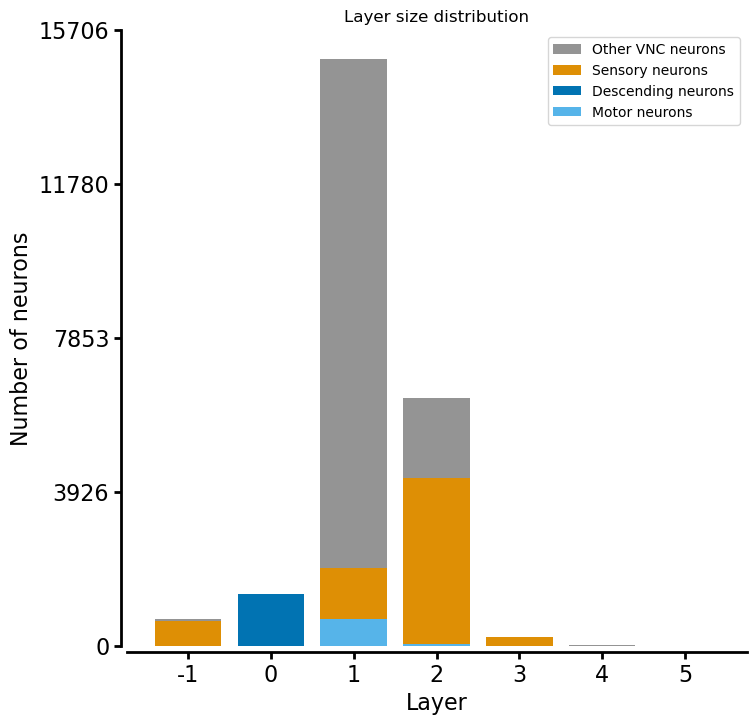

In [27]:
def mn_in_layer(
    layer: int,
    layer_dict: dict,
    motor_neurons_: list[UID],
) -> int:
    """
    Count the number of motor neurons in a given layer
    """
    # Get the neurons in the layer
    layer_neurons = [n for n, l in layer_dict.items() if l == layer]
    # Count the number of motor neurons in the layer
    mn_count = len([n for n in layer_neurons if n in motor_neurons_])
    return mn_count


# Draw the layer size distribution
print(layer_size)
layer_size_df = pd.DataFrame.from_dict(layer_size, orient="index")
layer_size_df = layer_size_df.reset_index()
layer_size_df.columns = ["layer", "size"]
layer_size_df = layer_size_df.sort_values(by="layer")
layer_size_df = layer_size_df.reset_index(drop=True)
# Add a column with the nb of motor neurons in each layer
layer_size_df["motor_neurons"] = layer_size_df["layer"].apply(
    lambda x: mn_in_layer(x, layer_dict, motor_neurons)
)
layer_size_df["sensory_neurons"] = layer_size_df["layer"].apply(
    lambda x: mn_in_layer(x, layer_dict, sensory_neurons)
)
layer_size_df["descending_neurons"] = 0
layer_size_df.loc[layer_size_df['layer'] == 0, 'descending_neurons'] = layer_size_df['size']
layer_size_df["interneurons"] = (
    layer_size_df["size"]
    - layer_size_df["descending_neurons"]
    - layer_size_df["sensory_neurons"]
    - layer_size_df["motor_neurons"]
)
# Draw 
layer_size_df["motor_and_sensory"] = ( # plot is cumulative
    layer_size_df["motor_neurons"]
    + layer_size_df["sensory_neurons"]
)
fig, ax = plt.subplots(1, 1, figsize=params.FIGSIZE)
ax.bar(
    layer_size_df["layer"],
    layer_size_df["size"],
    label="Other VNC neurons",
    color=params.DARKGREY,
)
ax.bar(
    layer_size_df["layer"],
    layer_size_df["motor_and_sensory"],
    label="Sensory neurons",  # motor neurons will be masked just after
    color=params.LIGHTORANGE,
)
ax.bar(
    layer_size_df["layer"],
    layer_size_df["descending_neurons"],
    label="Descending neurons",
    color=params.DARKBLUE,
)
ax.bar(
    layer_size_df["layer"],
    layer_size_df["motor_neurons"],
    label="Motor neurons",
    color=params.LIGHTBLUE,
)
ax.set_xlabel("Layer")
ax.set_ylabel("Number of neurons")
ax.set_title("Layer size distribution")
ax.legend()
plots_design.make_nice_spines(ax)
#ax.set_yticks([0, 5000, 10000, 15000])
#ax.set_yticklabels([0, 5000, 10000, 15000])
ax.set_xticks(layer_size_df["layer"])
ax.set_xticklabels(layer_size_df["layer"])
if savefigs:
    plt.savefig(
        os.path.join(MDN_FIGS, "layer_size_distribution.pdf"),
        dpi=params.DPI,
        bbox_inches="tight",
    )
plt.show()


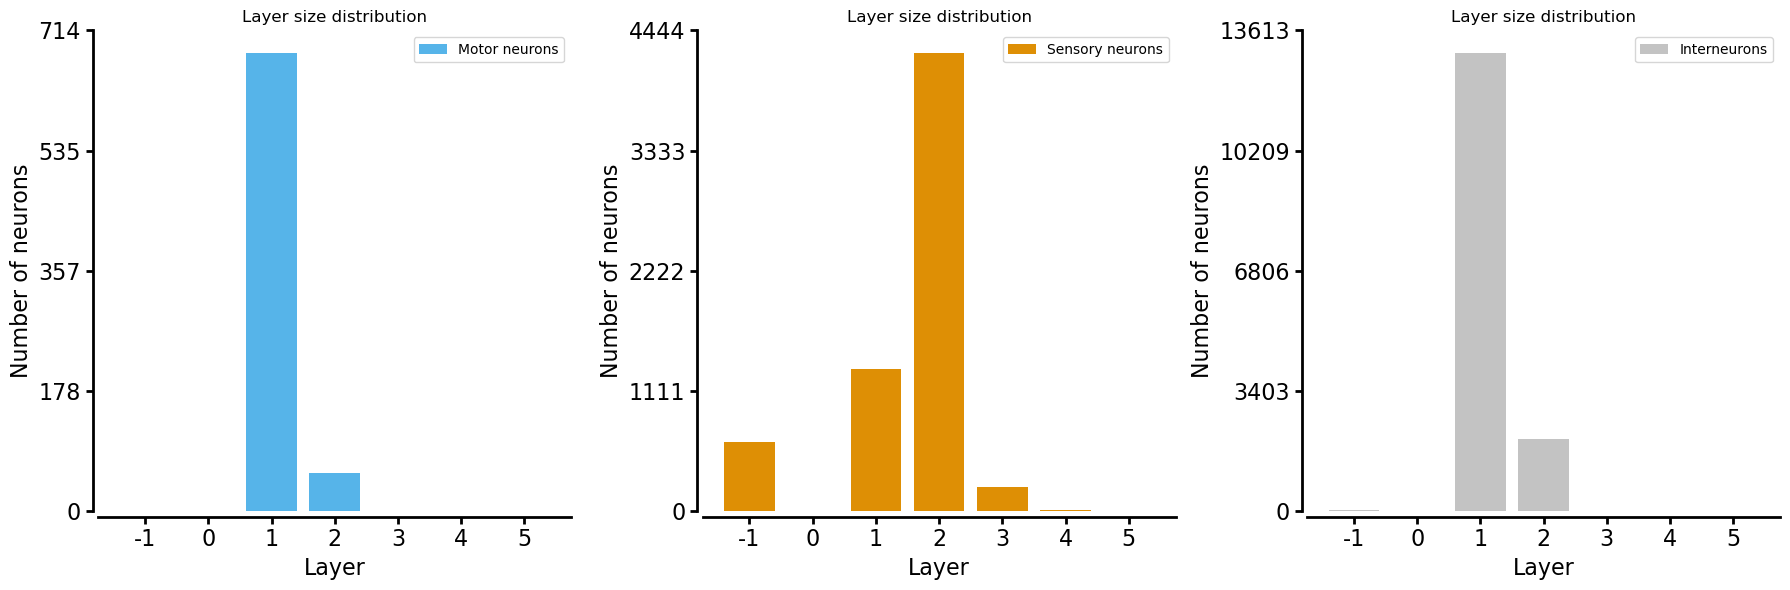

In [28]:
_, axs = plt.subplots(1,3, figsize=(18, 6))
# Plot the layer size distribution per neuron type
axs[0].bar(
    layer_size_df["layer"],
    layer_size_df["motor_neurons"],
    label="Motor neurons",
    color=params.LIGHTBLUE,
)
axs[1].bar(
    layer_size_df["layer"],
    layer_size_df["sensory_neurons"],
    label="Sensory neurons",
    color=params.LIGHTORANGE,
)
axs[2].bar(
    layer_size_df["layer"],
    layer_size_df["interneurons"],
    label="Interneurons",
    color=params.LIGHTGREY,
)
for ax in axs:
    ax.set_xlabel("Layer")
    ax.set_ylabel("Number of neurons")
    ax.set_title("Layer size distribution")
    ax.legend()
    plots_design.make_nice_spines(ax)
    ax.set_xticks(layer_size_df["layer"])
    ax.set_xticklabels(layer_size_df["layer"])
plt.tight_layout()

if savefigs:
    plt.savefig(
        os.path.join(MDN_FIGS, "layer_size_distribution_per_neuron_type_split.pdf"),
        dpi=params.DPI,
        bbox_inches="tight",
    )

In [32]:
print(layer_size_df)

   layer   size  motor_neurons  sensory_neurons  descending_neurons  \
0     -1    682              0              638                   0   
1      0   1328              0                0                1328   
2      1  14959            680             1314                   0   
3      2   6318             56             4233                   0   
4      3    239              0              225                   0   
5      4     16              0               14                   0   
6      5      1              0                1                   0   

   interneurons  motor_and_sensory  
0            44                638  
1             0                  0  
2         12965               1994  
3          2029               4289  
4            14                225  
5             2                 14  
6             0                  1  


In [26]:
if savefigs:
    # Save the layer_dict as a dataframe to csv
    layer_dict_df = pd.DataFrame.from_dict(layer_dict, orient="index")
    layer_dict_df = layer_dict_df.reset_index()
    layer_dict_df.columns = ["uid", "layer"]
    layer_dict_df["body_id"] = layer_dict_df["uid"].apply(
        lambda x: vanilla_vnc.get_bodyids_from_uids(x)[0]
    )

    # Save the dataframe to csv
    layer_dict_df.to_csv(
        os.path.join(MDN_FIGS, "layer_dict.csv"),
        index=False,
    )

## Per-MN input from layers

### Unweighted (nb conenctions)

In [29]:
# layer_dict has the layer assignment for each neuron
def layer_input_to_mn(
    mn_: UID,  # which target
    layer_dict_: dict,  # info about the layers
    cmat: CMatrix,  # connectivity matrix
    weighted: bool = False,  # use weighted connections
    threshold: int = params.SYNAPSE_CUTOFF,  # synapse threshold
) -> float:
    """
    Compute the layer-weighted direct input to a given motor neuron
    """
    # Threshold the connections
    cmat_ = copy.deepcopy(cmat)
    if threshold > params.SYNAPSE_CUTOFF:
        cmat_.threshold(threshold)

    # Get the neurons upstream of the motor neuron
    upstream_neurons_ = cmat_.list_upstream_neurons([mn_])

    # Sum the contributions from each layer
    layer_contributions = 0
    total_weights = 0
        
    for n in upstream_neurons_:
        try:
            layer = layer_dict_[n]
        except KeyError:
            # If the neuron is not in the layer_dict, it is a sensory neuron
            # and should be ignored
            continue
        if layer == -1:
            # If the neuron is not assigned to a layer, ignore it
            continue
        weight = np.abs(cmat_.get_mat_entry(n, mn_))
        assert weight >= 0, f"This should not be an entry"
        if weighted:
            layer_contributions +=weight*layer
            total_weights += weight
        else:
            layer_contributions += layer
            total_weights += 1 # count the number of connections with an assigned layer

    # Normalize by the number of upstream neurons
    layer_contributions /= total_weights
    
    return layer_contributions



In [30]:
unweighted_contributions = []
weighted_contributions = []
for mn_ in motor_neurons:
    unweighted_contributions.append(
        layer_input_to_mn(
            mn_,
            layer_dict,
            cmat=clean_cmat,
            weighted=False,
        )
    )
    weighted_contributions.append(
        layer_input_to_mn(
            mn_,
            layer_dict,
            cmat=clean_cmat,
            weighted=True,
        )
    )

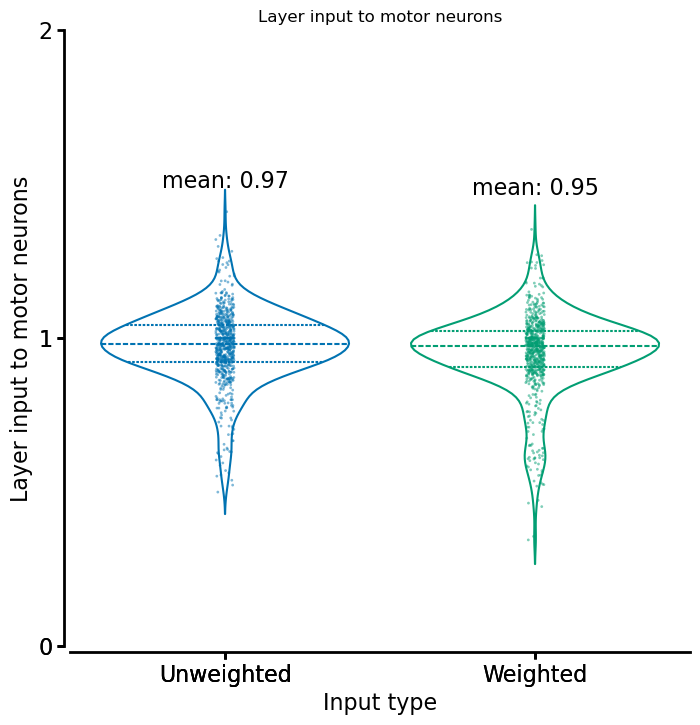

In [62]:

# Plot the results as a violin plot
fig, ax = plt.subplots(1, 1, figsize=params.FIGSIZE)
sns.violinplot(
    data=[unweighted_contributions, weighted_contributions],
    ax=ax,
    palette=params.custom_palette[:2],
    bw_method=0.3,
    split=False,
    inner="quart",
    fill=False,
)
sns.stripplot(  # stripplot, swarmplot
    data=[unweighted_contributions, weighted_contributions],
    ax=ax,
    palette=params.custom_palette[:2],
    jitter=0.03,
    alpha=0.5,
    size=2,
)
ax.set_ylabel("Layer input to motor neurons")
ax.set_xlabel("Input type")
ax.set_xticks([0, 1])
ax.set_xticklabels(["Unweighted", "Weighted"])
ax.set_yticks([0, 1, 2])
ax.set_yticklabels([0, 1, 2])
ax.set_title("Layer input to motor neurons")

# add labels with the mean values
mean_unweighted = np.mean(unweighted_contributions)
mean_weighted = np.mean(weighted_contributions)
ax.text(
    x=0,
    y=mean_unweighted + 0.5,
    s=f"mean: {mean_unweighted:.2f}",
    fontsize=params.LABEL_SIZE,
    ha="center",
    va="bottom",
)
ax.text(
    x=1,
    y=mean_weighted + 0.5,
    s=f"mean: {mean_weighted:.2f}",
    fontsize=params.LABEL_SIZE,
    ha="center",
    va="bottom",
)

plots_design.make_nice_spines(ax)

if savefigs:
    plt.savefig(
        os.path.join(MDN_FIGS, "layer_input_to_motor_neurons_violin.pdf"),
        dpi=params.DPI,
        bbox_inches="tight",
    )

plt.show()